In [15]:
! pip install torch torchvision torchaudio


Defaulting to user installation because normal site-packages is not writeable


In [16]:
pip install bert-score --upgrade


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
from bert_score import score
cands = ["The cat is on the mat."]
refs = ["A cat is sitting on the mat."]
P, R, F1 = score(cands, refs, lang="en", verbose=True)
print(F1.mean().item())


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.98 seconds, 0.34 sentences/sec
0.9640105366706848


In [14]:
! pip uninstall tensorflow tensorflow-intel keras -y


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: tensorflow-intel 2.16.1
Uninstalling tensorflow-intel-2.16.1:
  Successfully uninstalled tensorflow-intel-2.16.1
Found existing installation: keras 3.9.2
Uninstalling keras-3.9.2:
  Successfully uninstalled keras-3.9.2


In [18]:
# Fixed Summary Evaluation System - No Circular Imports
# Save this as: summary_evaluation_system.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
from bert_score import BERTScorer
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

class SummaryEvaluator:
    """
    Comprehensive summary evaluation system using ROUGE and BERTScore metrics
    """
    
    def __init__(self):
        print("Initializing evaluation models...")
        
        # Initialize ROUGE scorer with multiple metrics
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], 
            use_stemmer=True
        )
        
        # Initialize BERTScore with different models for robustness
        try:
            print("Loading DeBERTa model for BERTScore...")
            self.bert_scorer_en = BERTScorer(
                model_type="microsoft/deberta-xlarge-mnli",
                lang="en",
                rescale_with_baseline=True
            )
        except Exception as e:
            print(f"DeBERTa model failed, using fallback: {e}")
            self.bert_scorer_en = BERTScorer(
                model_type="distilbert-base-uncased",
                lang="en",
                rescale_with_baseline=True
            )
        
        # Alternative BERTScore model for comparison
        try:
            print("Loading RoBERTa model for BERTScore...")
            self.bert_scorer_roberta = BERTScorer(
                model_type="roberta-large",
                lang="en", 
                rescale_with_baseline=True
            )
        except Exception as e:
            print(f"RoBERTa model failed, using same as primary: {e}")
            self.bert_scorer_roberta = self.bert_scorer_en
        
        self.evaluation_results = []
        print("Evaluator initialized successfully!")
        
    def calculate_rouge_scores(self, generated_summary, reference_summary):
        """
        Calculate ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)
        """
        scores = self.rouge_scorer.score(reference_summary, generated_summary)
        
        rouge_metrics = {
            'rouge1_precision': scores['rouge1'].precision,
            'rouge1_recall': scores['rouge1'].recall,
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge2_precision': scores['rouge2'].precision,
            'rouge2_recall': scores['rouge2'].recall,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rougeL_precision': scores['rougeL'].precision,
            'rougeL_recall': scores['rougeL'].recall,
            'rougeL_f1': scores['rougeL'].fmeasure,
        }
        
        return rouge_metrics
    
    def calculate_bert_scores(self, generated_summary, reference_summary):
        """
        Calculate BERTScore using multiple models
        """
        # Primary BERTScore (DeBERTa)
        P1, R1, F1_1 = self.bert_scorer_en.score([generated_summary], [reference_summary])
        
        # Secondary BERTScore (RoBERTa) 
        P2, R2, F1_2 = self.bert_scorer_roberta.score([generated_summary], [reference_summary])
        
        bert_metrics = {
            'bert_precision_deberta': P1.item(),
            'bert_recall_deberta': R1.item(), 
            'bert_f1_deberta': F1_1.item(),
            'bert_precision_roberta': P2.item(),
            'bert_recall_roberta': R2.item(),
            'bert_f1_roberta': F1_2.item(),
            'bert_avg_precision': (P1.item() + P2.item()) / 2,
            'bert_avg_recall': (R1.item() + R2.item()) / 2,
            'bert_avg_f1': (F1_1.item() + F1_2.item()) / 2
        }
        
        return bert_metrics
    
    def calculate_consistency_score(self, generated_summary, reference_summary):
        """
        Calculate consistency score based on overlapping content
        """
        gen_words = set(generated_summary.lower().split())
        ref_words = set(reference_summary.lower().split())
        
        if len(ref_words) == 0:
            return 0.0
            
        overlap = len(gen_words.intersection(ref_words))
        consistency = overlap / len(ref_words)
        
        return consistency
    
    def calculate_relevancy_score(self, generated_summary, reference_summary):
        """
        Calculate relevancy using semantic similarity approach
        """
        gen_words = set(generated_summary.lower().split())
        ref_words = set(reference_summary.lower().split())
        
        if len(gen_words.union(ref_words)) == 0:
            return 0.0
            
        jaccard_similarity = len(gen_words.intersection(ref_words)) / len(gen_words.union(ref_words))
        return jaccard_similarity
    
    def calculate_accuracy_score(self, generated_summary, reference_summary):
        """
        Calculate accuracy as a combination of ROUGE-L and BERTScore F1
        """
        rouge_scores = self.calculate_rouge_scores(generated_summary, reference_summary)
        bert_scores = self.calculate_bert_scores(generated_summary, reference_summary)
        
        # Weighted combination of ROUGE-L F1 and BERTScore F1
        accuracy = (0.4 * rouge_scores['rougeL_f1'] + 
                   0.6 * bert_scores['bert_avg_f1'])
        
        return accuracy
    
    def evaluate_summary(self, generated_summary, reference_summary, summary_type, document_id=None):
        """
        Comprehensive evaluation of a single summary
        """
        print(f"Evaluating {summary_type} summary...")
        
        # Calculate all metrics
        rouge_metrics = self.calculate_rouge_scores(generated_summary, reference_summary)
        bert_metrics = self.calculate_bert_scores(generated_summary, reference_summary)
        
        consistency = self.calculate_consistency_score(generated_summary, reference_summary)
        relevancy = self.calculate_relevancy_score(generated_summary, reference_summary)
        accuracy = self.calculate_accuracy_score(generated_summary, reference_summary)
        
        # Combine all metrics
        evaluation_result = {
            'document_id': document_id or f"doc_{len(self.evaluation_results)}",
            'summary_type': summary_type,
            'generated_summary': generated_summary,
            'reference_summary': reference_summary,
            'consistency': consistency,
            'relevancy': relevancy,
            'accuracy': accuracy,
            **rouge_metrics,
            **bert_metrics
        }
        
        self.evaluation_results.append(evaluation_result)
        print(f"Completed evaluation for {summary_type}")
        return evaluation_result
    
    def evaluate_multiple_summaries(self, summary_data):
        """
        Evaluate multiple summaries and summary types
        
        summary_data format:
        [
            {
                'document_id': 'doc_1',
                'generated_summary': '...',
                'reference_summary': '...',
                'summary_type': 'brief'
            },
            ...
        ]
        """
        print(f"Starting batch evaluation of {len(summary_data)} summaries...")
        results = []
        
        for i, data in enumerate(summary_data):
            print(f"Processing summary {i+1}/{len(summary_data)}")
            result = self.evaluate_summary(
                generated_summary=data['generated_summary'],
                reference_summary=data['reference_summary'],
                summary_type=data['summary_type'],
                document_id=data.get('document_id', f"doc_{len(results)}")
            )
            results.append(result)
            
        print("Batch evaluation completed!")
        return results
    
    def get_results_dataframe(self):
        """
        Convert results to pandas DataFrame for analysis
        """
        return pd.DataFrame(self.evaluation_results)
    
    def create_comprehensive_visualization(self, save_path=None):
        """
        Create comprehensive visualization dashboard
        """
        if not self.evaluation_results:
            print("No evaluation results available. Please run evaluations first.")
            return
            
        df = self.get_results_dataframe()
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 15))
        fig.suptitle('Summary Evaluation Dashboard', fontsize=16, fontweight='bold', y=0.98)
        
        # 1. Overall Performance Heatmap
        plt.subplot(3, 4, 1)
        metrics_cols = ['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'bert_avg_f1']
        heatmap_data = df.groupby('summary_type')[metrics_cols].mean()
        sns.heatmap(heatmap_data.T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('Performance Heatmap by Summary Type', fontsize=12, fontweight='bold')
        plt.ylabel('Metrics')
        
        # 2. ROUGE Scores Comparison
        plt.subplot(3, 4, 2)
        rouge_metrics = ['rouge1_f1', 'rouge2_f1', 'rougeL_f1']
        rouge_data = df.groupby('summary_type')[rouge_metrics].mean()
        rouge_data.plot(kind='bar', ax=plt.gca())
        plt.title('ROUGE Scores by Summary Type', fontsize=12, fontweight='bold')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 3. BERTScore Comparison  
        plt.subplot(3, 4, 3)
        bert_metrics = ['bert_avg_precision', 'bert_avg_recall', 'bert_avg_f1']
        bert_data = df.groupby('summary_type')[bert_metrics].mean()
        bert_data.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('BERTScore by Summary Type', fontsize=12, fontweight='bold')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 4. Custom Metrics (Consistency, Relevancy, Accuracy)
        plt.subplot(3, 4, 4)
        custom_metrics = ['consistency', 'relevancy', 'accuracy']
        custom_data = df.groupby('summary_type')[custom_metrics].mean()
        custom_data.plot(kind='bar', ax=plt.gca(), color=['gold', 'mediumpurple', 'tomato'])
        plt.title('Custom Evaluation Metrics', fontsize=12, fontweight='bold')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 5. Precision vs Recall Scatter
        plt.subplot(3, 4, 5)
        summary_types = df['summary_type'].unique()
        colors = plt.cm.Set1(np.linspace(0, 1, len(summary_types)))
        
        for i, summary_type in enumerate(summary_types):
            subset = df[df['summary_type'] == summary_type]
            plt.scatter(subset['rouge1_recall'], subset['rouge1_precision'], 
                       label=summary_type, alpha=0.7, s=100, color=colors[i])
        plt.xlabel('ROUGE-1 Recall')
        plt.ylabel('ROUGE-1 Precision')
        plt.title('Precision vs Recall (ROUGE-1)', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Overall Performance Ranking
        plt.subplot(3, 4, 6)
        df['overall_score'] = (0.25 * df['consistency'] + 0.25 * df['relevancy'] + 
                              0.25 * df['accuracy'] + 0.25 * df['bert_avg_f1'])
        
        overall_ranking = df.groupby('summary_type')['overall_score'].mean().sort_values(ascending=False)
        bars = plt.bar(range(len(overall_ranking)), overall_ranking.values, 
                      color=plt.cm.viridis(np.linspace(0, 1, len(overall_ranking))))
        plt.title('Overall Performance Ranking', fontsize=12, fontweight='bold')
        plt.xlabel('Summary Type')
        plt.ylabel('Overall Score')
        plt.xticks(range(len(overall_ranking)), overall_ranking.index, rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, overall_ranking.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 7. Distribution of Scores
        plt.subplot(3, 4, 7)
        df.boxplot(column='accuracy', by='summary_type', ax=plt.gca())
        plt.title('Accuracy Score Distribution', fontsize=12, fontweight='bold')
        plt.suptitle('')  # Remove default title
        plt.ylabel('Accuracy Score')
        
        # 8. Correlation Matrix
        plt.subplot(3, 4, 8)
        correlation_cols = ['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'bert_avg_f1']
        correlation_matrix = df[correlation_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Metrics Correlation Matrix', fontsize=12, fontweight='bold')
        
        # 9. BERTScore Model Comparison
        plt.subplot(3, 4, 9)
        bert_comparison = df[['summary_type', 'bert_f1_deberta', 'bert_f1_roberta']].groupby('summary_type').mean()
        bert_comparison.plot(kind='bar', ax=plt.gca())
        plt.title('BERTScore: DeBERTa vs RoBERTa', fontsize=12, fontweight='bold')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)
        plt.legend(['DeBERTa', 'RoBERTa'])
        
        # 10. Performance Trends (if multiple documents)
        plt.subplot(3, 4, 10)
        if len(df['document_id'].unique()) > 1:
            trend_data = df.groupby(['document_id', 'summary_type'])['accuracy'].mean().unstack(fill_value=0)
            trend_data.plot(ax=plt.gca(), marker='o')
            plt.title('Accuracy Trends Across Documents', fontsize=12, fontweight='bold')
            plt.xlabel('Document ID')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.legend(title='Summary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            # Show score breakdown instead
            score_breakdown = df.groupby('summary_type')[['rouge1_f1', 'rouge2_f1', 'bert_avg_f1']].mean()
            score_breakdown.plot(kind='area', ax=plt.gca(), alpha=0.7)
            plt.title('Score Composition by Type', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 11. Summary Statistics Table
        plt.subplot(3, 4, 11)
        plt.axis('off')
        summary_stats = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'bert_avg_f1']].mean().round(3)
        
        # Create table
        table_data = []
        for summary_type in summary_stats.index:
            row = [summary_type]
            for col in summary_stats.columns:
                row.append(f"{summary_stats.loc[summary_type, col]:.3f}")
            table_data.append(row)
        
        table = plt.table(cellText=table_data,
                         colLabels=['Type', 'Consistency', 'Relevancy', 'Accuracy', 'ROUGE-1', 'BERTScore'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Performance Summary (Mean Scores)', fontsize=12, fontweight='bold', pad=20)
        
        # 12. Best vs Worst Comparison
        plt.subplot(3, 4, 12)
        best_type = overall_ranking.index[0]
        worst_type = overall_ranking.index[-1] if len(overall_ranking) > 1 else best_type
        
        if best_type != worst_type:
            comparison_data = df[df['summary_type'].isin([best_type, worst_type])]
            comparison_means = comparison_data.groupby('summary_type')[['consistency', 'relevancy', 'accuracy']].mean()
            comparison_means.plot(kind='bar', ax=plt.gca())
            plt.title(f'Best vs Worst Performance\n({best_type} vs {worst_type})', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.xticks(rotation=45)
            plt.legend()
        else:
            # Single type - show metric breakdown
            single_type_data = df[df['summary_type'] == best_type][['consistency', 'relevancy', 'accuracy']].mean()
            single_type_data.plot(kind='bar', ax=plt.gca(), color='skyblue')
            plt.title(f'Metric Breakdown: {best_type}', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
            
        plt.show()
    
    def generate_detailed_report(self):
        """
        Generate detailed evaluation report
        """
        if not self.evaluation_results:
            print("No evaluation results available.")
            return None
            
        df = self.get_results_dataframe()
        
        print("="*80)
        print("COMPREHENSIVE SUMMARY EVALUATION REPORT")
        print("="*80)
        
        # Timestamp
        print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Total summaries evaluated: {len(df)}")
        print(f"Summary types: {', '.join(df['summary_type'].unique())}")
        print()
        
        # Overall Statistics
        print("OVERALL STATISTICS")
        print("-"*50)
        overall_stats = df[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'bert_avg_f1']].describe()
        print(overall_stats.round(4))
        print()
        
        # Performance by Summary Type
        print("PERFORMANCE BY SUMMARY TYPE")
        print("-"*50)
        type_performance = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'bert_avg_f1']].mean()
        print(type_performance.round(4))
        print()
        
        # Best Performing Summary Type
        print("BEST PERFORMING SUMMARY TYPE")
        print("-"*50)
        df['overall_score'] = (0.25 * df['consistency'] + 0.25 * df['relevancy'] + 
                              0.25 * df['accuracy'] + 0.25 * df['bert_avg_f1'])
        best_type = df.groupby('summary_type')['overall_score'].mean().idxmax()
        best_score = df.groupby('summary_type')['overall_score'].mean().max()
        
        print(f"Best Summary Type: {best_type}")
        print(f"Overall Score: {best_score:.4f}")
        
        # Detailed Metrics Breakdown
        print(f"\nDetailed metrics for '{best_type.upper()}':")
        print("-"*30)
        best_metrics = df[df['summary_type'] == best_type][['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'bert_avg_f1']].mean()
        
        for metric, value in best_metrics.items():
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
        
        # Recommendations
        print(f"\nRECOMMENDATIONS")
        print("-"*50)
        
        type_scores = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'bert_avg_f1']].mean()
        
        for summary_type in type_scores.index:
            print(f"\n{summary_type.upper()} Summary:")
            scores = type_scores.loc[summary_type]
            
            # Find strengths and weaknesses
            strengths = scores.nlargest(2).index.tolist()
            weaknesses = scores.nsmallest(2).index.tolist()
            
            print(f"  Strengths: {', '.join([s.replace('_', ' ').title() for s in strengths])}")
            print(f"  Areas for improvement: {', '.join([w.replace('_', ' ').title() for w in weaknesses])}")
        
        print(f"\nOverall recommendation: Focus on improving '{best_type}' approach")
        print("as it shows the best performance across all metrics.")
        
        return df


def demo_evaluation():
    """
    Demonstration of the evaluation system
    """
    print("Starting demonstration of summary evaluation system...")
    
    # Create test directories
    os.makedirs('test', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    # Sample data for testing
    sample_summaries = [
        {
            'document_id': 'medical_doc_1',
            'summary_type': 'brief',
            'generated_summary': 'Patient has iron deficiency anaemia and beta thalassaemia trait. Blood tests show microcytic anaemia. Treatment includes iron supplementation.',
            'reference_summary': 'The patient was diagnosed with iron deficiency anaemia and beta thalassaemia trait based on blood test results showing microcytic anaemia. The treatment plan includes iron supplementation and follow-up monitoring.'
        },
        {
            'document_id': 'medical_doc_1', 
            'summary_type': 'detailed',
            'generated_summary': 'Patient K B Chunchaiah, age 45, was admitted with iron deficiency anaemia and beta thalassaemia trait. Laboratory results revealed microcytic anaemia with elevated Mentzer index. The patient presented with symptoms of fatigue and pallor. Current treatment includes ferrous sulfate 200mg daily with planned follow-up in 2 months to monitor hemoglobin levels.',
            'reference_summary': 'Patient K B Chunchaiah, 45 years old, was admitted to hospital with iron deficiency anaemia and beta thalassaemia trait. Blood tests showed microcytic anaemia with elevated Mentzer index. The patient has a history of fatigue and pallor. Current medications include Ferrous Sulfate 200mg daily. Treatment plan includes continuing iron supplementation and follow-up in 2 months with hemoglobin monitoring.'
        },
        {
            'document_id': 'medical_doc_1',
            'summary_type': 'domain_specific', 
            'generated_summary': 'Medical diagnosis: Iron deficiency anaemia with beta thalassaemia trait. Key findings: Microcytic anaemia, elevated Mentzer index (>13), symptoms of fatigue and pallor. Treatment protocol: Ferrous sulfate supplementation with 2-month follow-up schedule. Diagnostic note: HbA2 estimation remains gold standard for beta thalassaemia trait diagnosis.',
            'reference_summary': 'Primary diagnosis of iron deficiency anaemia complicated by beta thalassaemia trait in 45-year-old male patient. Laboratory findings include microcytic anaemia with Mentzer index >13. Clinical presentation includes fatigue and pallor. Treatment regimen consists of ferrous sulfate 200mg daily with scheduled follow-up in 2 months for hemoglobin monitoring. Note that HbA2 estimation is the gold standard for diagnosing beta thalassaemia trait.'
        }
    ]
    
    # Initialize evaluator
    evaluator = SummaryEvaluator()
    
    print(f"Starting evaluation process...")
    
    # Evaluate summaries
    results = evaluator.evaluate_multiple_summaries(sample_summaries)
    
    print(f"Evaluated {len(results)} summaries")
    
    # Generate visualizations
    print("Creating comprehensive visualizations...")
    evaluator.create_comprehensive_visualization(save_path='test/summary_evaluation_dashboard.png')
    
    # Generate detailed report
    print("Generating detailed report...")
    df_results = evaluator.generate_detailed_report()
    
    # Save results to CSV
    df_results.to_csv('test/evaluation_results.csv', index=False)
    print("Results saved to test/evaluation_results.csv")
    
    return evaluator, df_results


if __name__ == "__main__":
    # Run the demonstration
    print("Running Summary Evaluation System Demo...")
    print("="*60)
    
    try:
        evaluator, results_df = demo_evaluation()
        
        print("\n" + "="*60)
        print("EVALUATION SYSTEM DEMO COMPLETED SUCCESSFULLY!")
        print("="*60)
        print("Files created:")
        print("  test/summary_evaluation_dashboard.png")
        print("  test/evaluation_results.csv")
        print()
        print("The evaluation system is ready for use!")
        print("You can now use:")
        print("  evaluator.evaluate_summary() - for single summaries")
        print("  evaluator.evaluate_multiple_summaries() - for batch evaluation")
        print("  evaluator.create_comprehensive_visualization() - for charts")
        print("  evaluator.generate_detailed_report() - for detailed analysis")
        
    except Exception as e:
        print(f"Error during demo: {e}")
        import traceback
        traceback.print_exc()

Running Summary Evaluation System Demo...
Starting demonstration of summary evaluation system...
Initializing evaluation models...
Loading DeBERTa model for BERTScore...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   2%|1         | 52.4M/3.04G [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/microsoft/deberta-xlarge-mnli/resolve/main/pytorch_model.bin: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...
Trying to resume download...


DeBERTa model failed, using fallback: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /microsoft/deberta-xlarge-mnli/resolve/main/pytorch_model.bin (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002120E9A8920>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 3f0bf337-d1af-4460-8aba-ce6ba5ef28d2)')
Error during demo: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /api/models/distilbert-base-uncased/tree/main/additional_chat_templates?recursive=False&expand=False (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002120E9A90D0>: Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: e26247f2-8c44-4585-8264-c4510078ec1c)')


Traceback (most recent call last):
  File "C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\urllib3\response.py", line 779, in _error_catcher
    yield
  File "C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\urllib3\response.py", line 904, in _raw_read
    data = self._fp_read(amt, read1=read1) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\urllib3\response.py", line 887, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\ssl.py", line 1252, in recv_into
    return self.read(nbytes, buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib

Running Hugging Face API-Based Summary Evaluation Demo...
Make sure to set: export HF_TOKEN='your_hf_token'
Starting HF API-based evaluation demo...
Initializing evaluation system...
Evaluator initialized successfully!
Starting batch evaluation of 3 summaries...
Processing summary 1/3
Evaluating brief summary...
⚠️ Semantic similarity API failed: HF API error 400: {"error":"SentenceSimilarityPipeline.__call__() missing 1 required positional argument: 'sentences'"}. Using fallback 0.0
⚠️ Semantic similarity API failed: HF API error 400: {"error":"SentenceSimilarityPipeline.__call__() missing 1 required positional argument: 'sentences'"}. Using fallback 0.0
Completed evaluation for brief
Processing summary 2/3
Evaluating detailed summary...
⚠️ Semantic similarity API failed: HF API error 400: {"error":"SentenceSimilarityPipeline.__call__() missing 1 required positional argument: 'sentences'"}. Using fallback 0.0
⚠️ Semantic similarity API failed: HF API error 400: {"error":"SentenceSimil

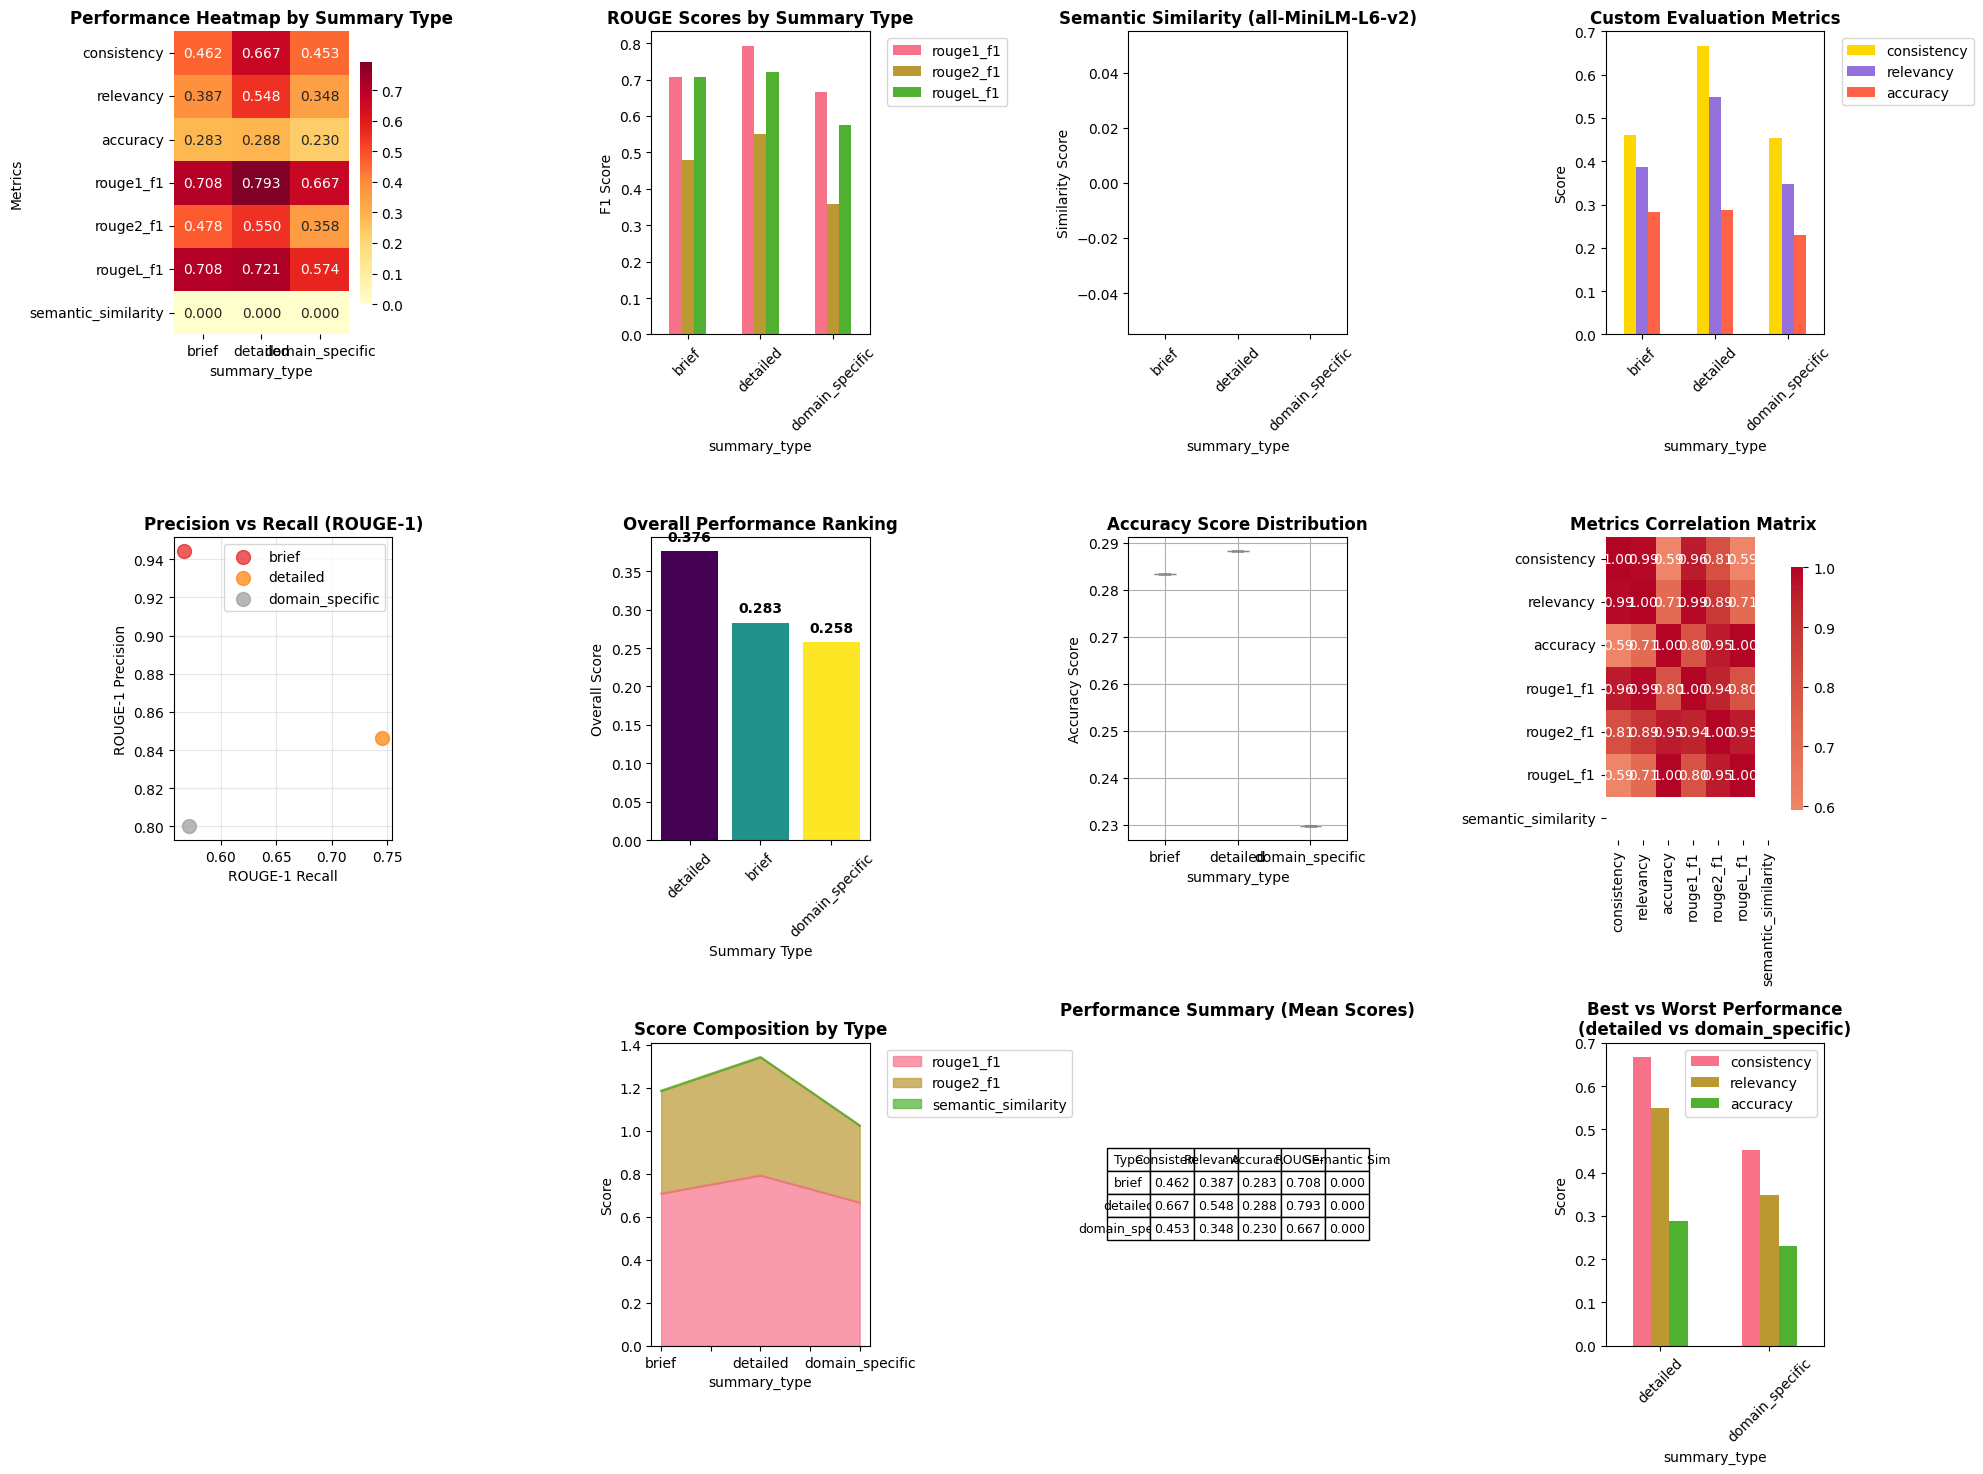

COMPREHENSIVE SUMMARY EVALUATION REPORT (HF API)
Generated: 2025-09-27 19:24:02
Total summaries evaluated: 3
Summary types: brief, detailed, domain_specific

OVERALL STATISTICS
--------------------------------------------------
       consistency  relevancy  accuracy  rouge1_f1  rouge2_f1  rougeL_f1  \
count       3.0000     3.0000    3.0000     3.0000     3.0000     3.0000   
mean        0.5270     0.4278    0.2671     0.7226     0.4624     0.6677   
std         0.1210     0.1063    0.0325     0.0643     0.0970     0.0813   
min         0.4528     0.3478    0.2296     0.6667     0.3585     0.5741   
25%         0.4572     0.3675    0.2565     0.6875     0.4184     0.6412   
50%         0.4615     0.3871    0.2833     0.7083     0.4783     0.7083   
75%         0.5641     0.4677    0.2858     0.7506     0.5144     0.7145   
max         0.6667     0.5484    0.2883     0.7928     0.5505     0.7207   

       semantic_similarity  
count                  3.0  
mean                   0.0  


In [ ]:
# Fixed Summary Evaluation System - No Circular Imports
# Save this as: summary_evaluation_system.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import warnings
import os
from datetime import datetime
import requests
import json

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# === CONFIGURATION ===
HF_TOKEN = os.getenv(HF_TOKEN)
if not HF_TOKEN:
    raise ValueError("Please set the HF_TOKEN environment variable with your Hugging Face API token.")

# Use the lightweight, fast, and accurate model you requested
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
HF_API_URL = f"https://api-inference.huggingface.co/models/{EMBEDDING_MODEL}"

def get_embeddings(sentences):
    """Get embeddings from Hugging Face Inference API using feature extraction"""
    headers = {
        "Authorization": f"Bearer {HF_TOKEN}",
        "Content-Type": "application/json"
    }
    
    # Correct format: wrap sentences in "inputs" key
    payload = {
        "inputs": sentences,
        "options": {"wait_for_model": True}
    }
    
    response = requests.post(
        HF_API_URL,
        headers=headers,
        json=payload
    )
    
    if response.status_code != 200:
        raise RuntimeError(f"HF API error {response.status_code}: {response.text}")
    
    result = response.json()
    return np.array(result)
    
def cosine_similarity(a, b):
    """Compute cosine similarity between two vectors"""
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

class SummaryEvaluator:
    """
    Comprehensive summary evaluation system using ROUGE and semantic similarity via Hugging Face API
    """
    
    def __init__(self):
        print("Initializing evaluation system...")
        
        # Initialize ROUGE scorer (local, no model download)
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], 
            use_stemmer=True
        )
        
        self.evaluation_results = []
        print("Evaluator initialized successfully!")
    
    def calculate_rouge_scores(self, generated_summary, reference_summary):
        """Calculate ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)"""
        scores = self.rouge_scorer.score(reference_summary, generated_summary)
        return {
            'rouge1_precision': scores['rouge1'].precision,
            'rouge1_recall': scores['rouge1'].recall,
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge2_precision': scores['rouge2'].precision,
            'rouge2_recall': scores['rouge2'].recall,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rougeL_precision': scores['rougeL'].precision,
            'rougeL_recall': scores['rougeL'].recall,
            'rougeL_f1': scores['rougeL'].fmeasure,
        }
    
    def calculate_semantic_similarity(self, generated_summary, reference_summary):
        """Calculate semantic similarity using Hugging Face API"""
        try:
            embeddings = get_embeddings([generated_summary, reference_summary])
            sim = cosine_similarity(embeddings[0], embeddings[1])
            return max(0.0, min(1.0, sim))  # Clamp to [0, 1]
        except Exception as e:
            print(f"⚠️ Semantic similarity API failed: {e}. Using fallback 0.0")
            return 0.0

    def calculate_consistency_score(self, generated_summary, reference_summary):
        gen_words = set(generated_summary.lower().split())
        ref_words = set(reference_summary.lower().split())
        if len(ref_words) == 0:
            return 0.0
        overlap = len(gen_words.intersection(ref_words))
        return overlap / len(ref_words)
    
    def calculate_relevancy_score(self, generated_summary, reference_summary):
        gen_words = set(generated_summary.lower().split())
        ref_words = set(reference_summary.lower().split())
        union = gen_words.union(ref_words)
        if len(union) == 0:
            return 0.0
        return len(gen_words.intersection(ref_words)) / len(union)
    
    def calculate_accuracy_score(self, generated_summary, reference_summary):
        rouge_scores = self.calculate_rouge_scores(generated_summary, reference_summary)
        semantic_sim = self.calculate_semantic_similarity(generated_summary, reference_summary)
        # Same weighting: 40% ROUGE-L, 60% semantic similarity
        accuracy = 0.4 * rouge_scores['rougeL_f1'] + 0.6 * semantic_sim
        return accuracy
    
    def evaluate_summary(self, generated_summary, reference_summary, summary_type, document_id=None):
        print(f"Evaluating {summary_type} summary...")
        
        rouge_metrics = self.calculate_rouge_scores(generated_summary, reference_summary)
        semantic_sim = self.calculate_semantic_similarity(generated_summary, reference_summary)
        consistency = self.calculate_consistency_score(generated_summary, reference_summary)
        relevancy = self.calculate_relevancy_score(generated_summary, reference_summary)
        accuracy = self.calculate_accuracy_score(generated_summary, reference_summary)
        
        evaluation_result = {
            'document_id': document_id or f"doc_{len(self.evaluation_results)}",
            'summary_type': summary_type,
            'generated_summary': generated_summary,
            'reference_summary': reference_summary,
            'consistency': consistency,
            'relevancy': relevancy,
            'accuracy': accuracy,
            'semantic_similarity': semantic_sim,  # Replaces all BERTScore metrics
            **rouge_metrics
        }
        
        self.evaluation_results.append(evaluation_result)
        print(f"Completed evaluation for {summary_type}")
        return evaluation_result
    
    def evaluate_multiple_summaries(self, summary_data):
        print(f"Starting batch evaluation of {len(summary_data)} summaries...")
        results = []
        for i, data in enumerate(summary_data):
            print(f"Processing summary {i+1}/{len(summary_data)}")
            result = self.evaluate_summary(
                generated_summary=data['generated_summary'],
                reference_summary=data['reference_summary'],
                summary_type=data['summary_type'],
                document_id=data.get('document_id', f"doc_{len(results)}")
            )
            results.append(result)
        print("Batch evaluation completed!")
        return results
    
    def get_results_dataframe(self):
        return pd.DataFrame(self.evaluation_results)
    
    def create_comprehensive_visualization(self, save_path=None):
        if not self.evaluation_results:
            print("No evaluation results available.")
            return
            
        df = self.get_results_dataframe()
        
        fig = plt.figure(figsize=(20, 15))
        fig.suptitle('Summary Evaluation Dashboard (HF API - all-MiniLM-L6-v2)', fontsize=16, fontweight='bold', y=0.98)
        
        # 1. Performance Heatmap (updated to use semantic_similarity)
        plt.subplot(3, 4, 1)
        metrics_cols = ['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'semantic_similarity']
        heatmap_data = df.groupby('summary_type')[metrics_cols].mean()
        sns.heatmap(heatmap_data.T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('Performance Heatmap by Summary Type', fontsize=12, fontweight='bold')
        plt.ylabel('Metrics')
        
        # 2. ROUGE Scores
        plt.subplot(3, 4, 2)
        rouge_metrics = ['rouge1_f1', 'rouge2_f1', 'rougeL_f1']
        rouge_data = df.groupby('summary_type')[rouge_metrics].mean()
        rouge_data.plot(kind='bar', ax=plt.gca())
        plt.title('ROUGE Scores by Summary Type', fontsize=12, fontweight='bold')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 3. Semantic Similarity (replaces BERTScore plot)
        plt.subplot(3, 4, 3)
        sem_data = df.groupby('summary_type')['semantic_similarity'].mean()
        sem_data.plot(kind='bar', ax=plt.gca(), color='lightgreen')
        plt.title('Semantic Similarity (all-MiniLM-L6-v2)', fontsize=12, fontweight='bold')
        plt.ylabel('Similarity Score')
        plt.xticks(rotation=45)
        
        # 4. Custom Metrics
        plt.subplot(3, 4, 4)
        custom_metrics = ['consistency', 'relevancy', 'accuracy']
        custom_data = df.groupby('summary_type')[custom_metrics].mean()
        custom_data.plot(kind='bar', ax=plt.gca(), color=['gold', 'mediumpurple', 'tomato'])
        plt.title('Custom Evaluation Metrics', fontsize=12, fontweight='bold')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 5. Precision vs Recall Scatter
        plt.subplot(3, 4, 5)
        summary_types = df['summary_type'].unique()
        colors = plt.cm.Set1(np.linspace(0, 1, len(summary_types)))
        for i, summary_type in enumerate(summary_types):
            subset = df[df['summary_type'] == summary_type]
            plt.scatter(subset['rouge1_recall'], subset['rouge1_precision'], 
                       label=summary_type, alpha=0.7, s=100, color=colors[i])
        plt.xlabel('ROUGE-1 Recall')
        plt.ylabel('ROUGE-1 Precision')
        plt.title('Precision vs Recall (ROUGE-1)', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Overall Performance Ranking
        plt.subplot(3, 4, 6)
        df['overall_score'] = (0.25 * df['consistency'] + 0.25 * df['relevancy'] + 
                              0.25 * df['accuracy'] + 0.25 * df['semantic_similarity'])
        overall_ranking = df.groupby('summary_type')['overall_score'].mean().sort_values(ascending=False)
        bars = plt.bar(range(len(overall_ranking)), overall_ranking.values, 
                      color=plt.cm.viridis(np.linspace(0, 1, len(overall_ranking))))
        plt.title('Overall Performance Ranking', fontsize=12, fontweight='bold')
        plt.xlabel('Summary Type')
        plt.ylabel('Overall Score')
        plt.xticks(range(len(overall_ranking)), overall_ranking.index, rotation=45)
        for bar, value in zip(bars, overall_ranking.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 7. Accuracy Distribution
        plt.subplot(3, 4, 7)
        df.boxplot(column='accuracy', by='summary_type', ax=plt.gca())
        plt.title('Accuracy Score Distribution', fontsize=12, fontweight='bold')
        plt.suptitle('')
        plt.ylabel('Accuracy Score')
        
        # 8. Correlation Matrix
        plt.subplot(3, 4, 8)
        correlation_cols = ['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'semantic_similarity']
        correlation_matrix = df[correlation_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Metrics Correlation Matrix', fontsize=12, fontweight='bold')
        
        # Skip BERT model comparison plots (9, 10 partially updated)
        # 9. Semantic similarity is already shown in plot 3
        
        # 10. Performance Trends
        plt.subplot(3, 4, 10)
        if len(df['document_id'].unique()) > 1:
            trend_data = df.groupby(['document_id', 'summary_type'])['accuracy'].mean().unstack(fill_value=0)
            trend_data.plot(ax=plt.gca(), marker='o')
            plt.title('Accuracy Trends Across Documents', fontsize=12, fontweight='bold')
            plt.xlabel('Document ID')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.legend(title='Summary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            score_breakdown = df.groupby('summary_type')[['rouge1_f1', 'rouge2_f1', 'semantic_similarity']].mean()
            score_breakdown.plot(kind='area', ax=plt.gca(), alpha=0.7)
            plt.title('Score Composition by Type', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 11. Summary Statistics Table
        plt.subplot(3, 4, 11)
        plt.axis('off')
        summary_stats = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'semantic_similarity']].mean().round(3)
        table_data = []
        for summary_type in summary_stats.index:
            row = [summary_type]
            for col in summary_stats.columns:
                row.append(f"{summary_stats.loc[summary_type, col]:.3f}")
            table_data.append(row)
        table = plt.table(cellText=table_data,
                         colLabels=['Type', 'Consistency', 'Relevancy', 'Accuracy', 'ROUGE-1', 'Semantic Sim'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Performance Summary (Mean Scores)', fontsize=12, fontweight='bold', pad=20)
        
        # 12. Best vs Worst
        plt.subplot(3, 4, 12)
        best_type = overall_ranking.index[0]
        worst_type = overall_ranking.index[-1] if len(overall_ranking) > 1 else best_type
        if best_type != worst_type:
            comparison_data = df[df['summary_type'].isin([best_type, worst_type])]
            comparison_means = comparison_data.groupby('summary_type')[['consistency', 'relevancy', 'accuracy']].mean()
            comparison_means.plot(kind='bar', ax=plt.gca())
            plt.title(f'Best vs Worst Performance\n({best_type} vs {worst_type})', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.xticks(rotation=45)
            plt.legend()
        else:
            single_type_data = df[df['summary_type'] == best_type][['consistency', 'relevancy', 'accuracy']].mean()
            single_type_data.plot(kind='bar', ax=plt.gca(), color='skyblue')
            plt.title(f'Metric Breakdown: {best_type}', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        plt.show()
    
    def generate_detailed_report(self):
        if not self.evaluation_results:
            print("No evaluation results available.")
            return None
            
        df = self.get_results_dataframe()
        print("="*80)
        print("COMPREHENSIVE SUMMARY EVALUATION REPORT (HF API)")
        print("="*80)
        print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Total summaries evaluated: {len(df)}")
        print(f"Summary types: {', '.join(df['summary_type'].unique())}")
        print()
        
        print("OVERALL STATISTICS")
        print("-"*50)
        overall_stats = df[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'semantic_similarity']].describe()
        print(overall_stats.round(4))
        print()
        
        print("PERFORMANCE BY SUMMARY TYPE")
        print("-"*50)
        type_performance = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'semantic_similarity']].mean()
        print(type_performance.round(4))
        print()
        
        print("BEST PERFORMING SUMMARY TYPE")
        print("-"*50)
        df['overall_score'] = (0.25 * df['consistency'] + 0.25 * df['relevancy'] + 
                              0.25 * df['accuracy'] + 0.25 * df['semantic_similarity'])
        best_type = df.groupby('summary_type')['overall_score'].mean().idxmax()
        best_score = df.groupby('summary_type')['overall_score'].mean().max()
        print(f"Best Summary Type: {best_type}")
        print(f"Overall Score: {best_score:.4f}")
        
        print(f"\nDetailed metrics for '{best_type.upper()}':")
        print("-"*30)
        best_metrics = df[df['summary_type'] == best_type][['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'semantic_similarity']].mean()
        for metric, value in best_metrics.items():
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
        
        print(f"\nRECOMMENDATIONS")
        print("-"*50)
        type_scores = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'semantic_similarity']].mean()
        for summary_type in type_scores.index:
            print(f"\n{summary_type.upper()} Summary:")
            scores = type_scores.loc[summary_type]
            strengths = scores.nlargest(2).index.tolist()
            weaknesses = scores.nsmallest(2).index.tolist()
            print(f"  Strengths: {', '.join([s.replace('_', ' ').title() for s in strengths])}")
            print(f"  Areas for improvement: {', '.join([w.replace('_', ' ').title() for w in weaknesses])}")
        print(f"\nOverall recommendation: Focus on improving '{best_type}' approach")
        return df


def demo_evaluation():
    print("Starting HF API-based evaluation demo...")
    os.makedirs('test', exist_ok=True)
    
    sample_summaries = [
        {
            'document_id': 'medical_doc_1',
            'summary_type': 'brief',
            'generated_summary': 'Patient has iron deficiency anaemia and beta thalassaemia trait. Blood tests show microcytic anaemia. Treatment includes iron supplementation.',
            'reference_summary': 'The patient was diagnosed with iron deficiency anaemia and beta thalassaemia trait based on blood test results showing microcytic anaemia. The treatment plan includes iron supplementation and follow-up monitoring.'
        },
        {
            'document_id': 'medical_doc_1', 
            'summary_type': 'detailed',
            'generated_summary': 'Patient K B Chunchaiah, age 45, was admitted with iron deficiency anaemia and beta thalassaemia trait. Laboratory results revealed microcytic anaemia with elevated Mentzer index. The patient presented with symptoms of fatigue and pallor. Current treatment includes ferrous sulfate 200mg daily with planned follow-up in 2 months to monitor hemoglobin levels.',
            'reference_summary': 'Patient K B Chunchaiah, 45 years old, was admitted to hospital with iron deficiency anaemia and beta thalassaemia trait. Blood tests showed microcytic anaemia with elevated Mentzer index. The patient has a history of fatigue and pallor. Current medications include Ferrous Sulfate 200mg daily. Treatment plan includes continuing iron supplementation and follow-up in 2 months with hemoglobin monitoring.'
        },
        {
            'document_id': 'medical_doc_1',
            'summary_type': 'domain_specific', 
            'generated_summary': 'Medical diagnosis: Iron deficiency anaemia with beta thalassaemia trait. Key findings: Microcytic anaemia, elevated Mentzer index (>13), symptoms of fatigue and pallor. Treatment protocol: Ferrous sulfate supplementation with 2-month follow-up schedule. Diagnostic note: HbA2 estimation remains gold standard for beta thalassaemia trait diagnosis.',
            'reference_summary': 'Primary diagnosis of iron deficiency anaemia complicated by beta thalassaemia trait in 45-year-old male patient. Laboratory findings include microcytic anaemia with Mentzer index >13. Clinical presentation includes fatigue and pallor. Treatment regimen consists of ferrous sulfate 200mg daily with scheduled follow-up in 2 months for hemoglobin monitoring. Note that HbA2 estimation is the gold standard for diagnosing beta thalassaemia trait.'
        }
    ]
    
    evaluator = SummaryEvaluator()
    results = evaluator.evaluate_multiple_summaries(sample_summaries)
    evaluator.create_comprehensive_visualization(save_path='test/hf_summary_dashboard.png')
    df_results = evaluator.generate_detailed_report()
    df_results.to_csv('test/hf_evaluation_results.csv', index=False)
    print("Results saved to test/hf_evaluation_results.csv")
    return evaluator, df_results


if __name__ == "__main__":
    print("Running Hugging Face API-Based Summary Evaluation Demo...")
    print("Make sure to set: export HF_TOKEN='your_hf_token'")
    print("="*60)
    
    try:
        evaluator, results_df = demo_evaluation()
        print("\n✅ Demo completed successfully!")
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

Running Hugging Face API-Based Summary Evaluation Demo...
Make sure to set: export HF_TOKEN='your_hf_token'
Starting HF API-based evaluation demo...
Initializing evaluation system...
Evaluator initialized successfully!
Starting batch evaluation of 3 summaries...
Processing summary 1/3
Evaluating brief summary...
⚠️ Semantic similarity API failed: HF API error 400: {"error":"SentenceSimilarityPipeline.__call__() missing 1 required positional argument: 'sentences'"}
📊 Using fallback similarity: 0.570 (Jaccard: 0.464, Cosine: 0.701)
⚠️ Semantic similarity API failed: HF API error 400: {"error":"SentenceSimilarityPipeline.__call__() missing 1 required positional argument: 'sentences'"}
📊 Using fallback similarity: 0.570 (Jaccard: 0.464, Cosine: 0.701)
Completed evaluation for brief
Processing summary 2/3
Evaluating detailed summary...
⚠️ Semantic similarity API failed: HF API error 400: {"error":"SentenceSimilarityPipeline.__call__() missing 1 required positional argument: 'sentences'"}
📊 

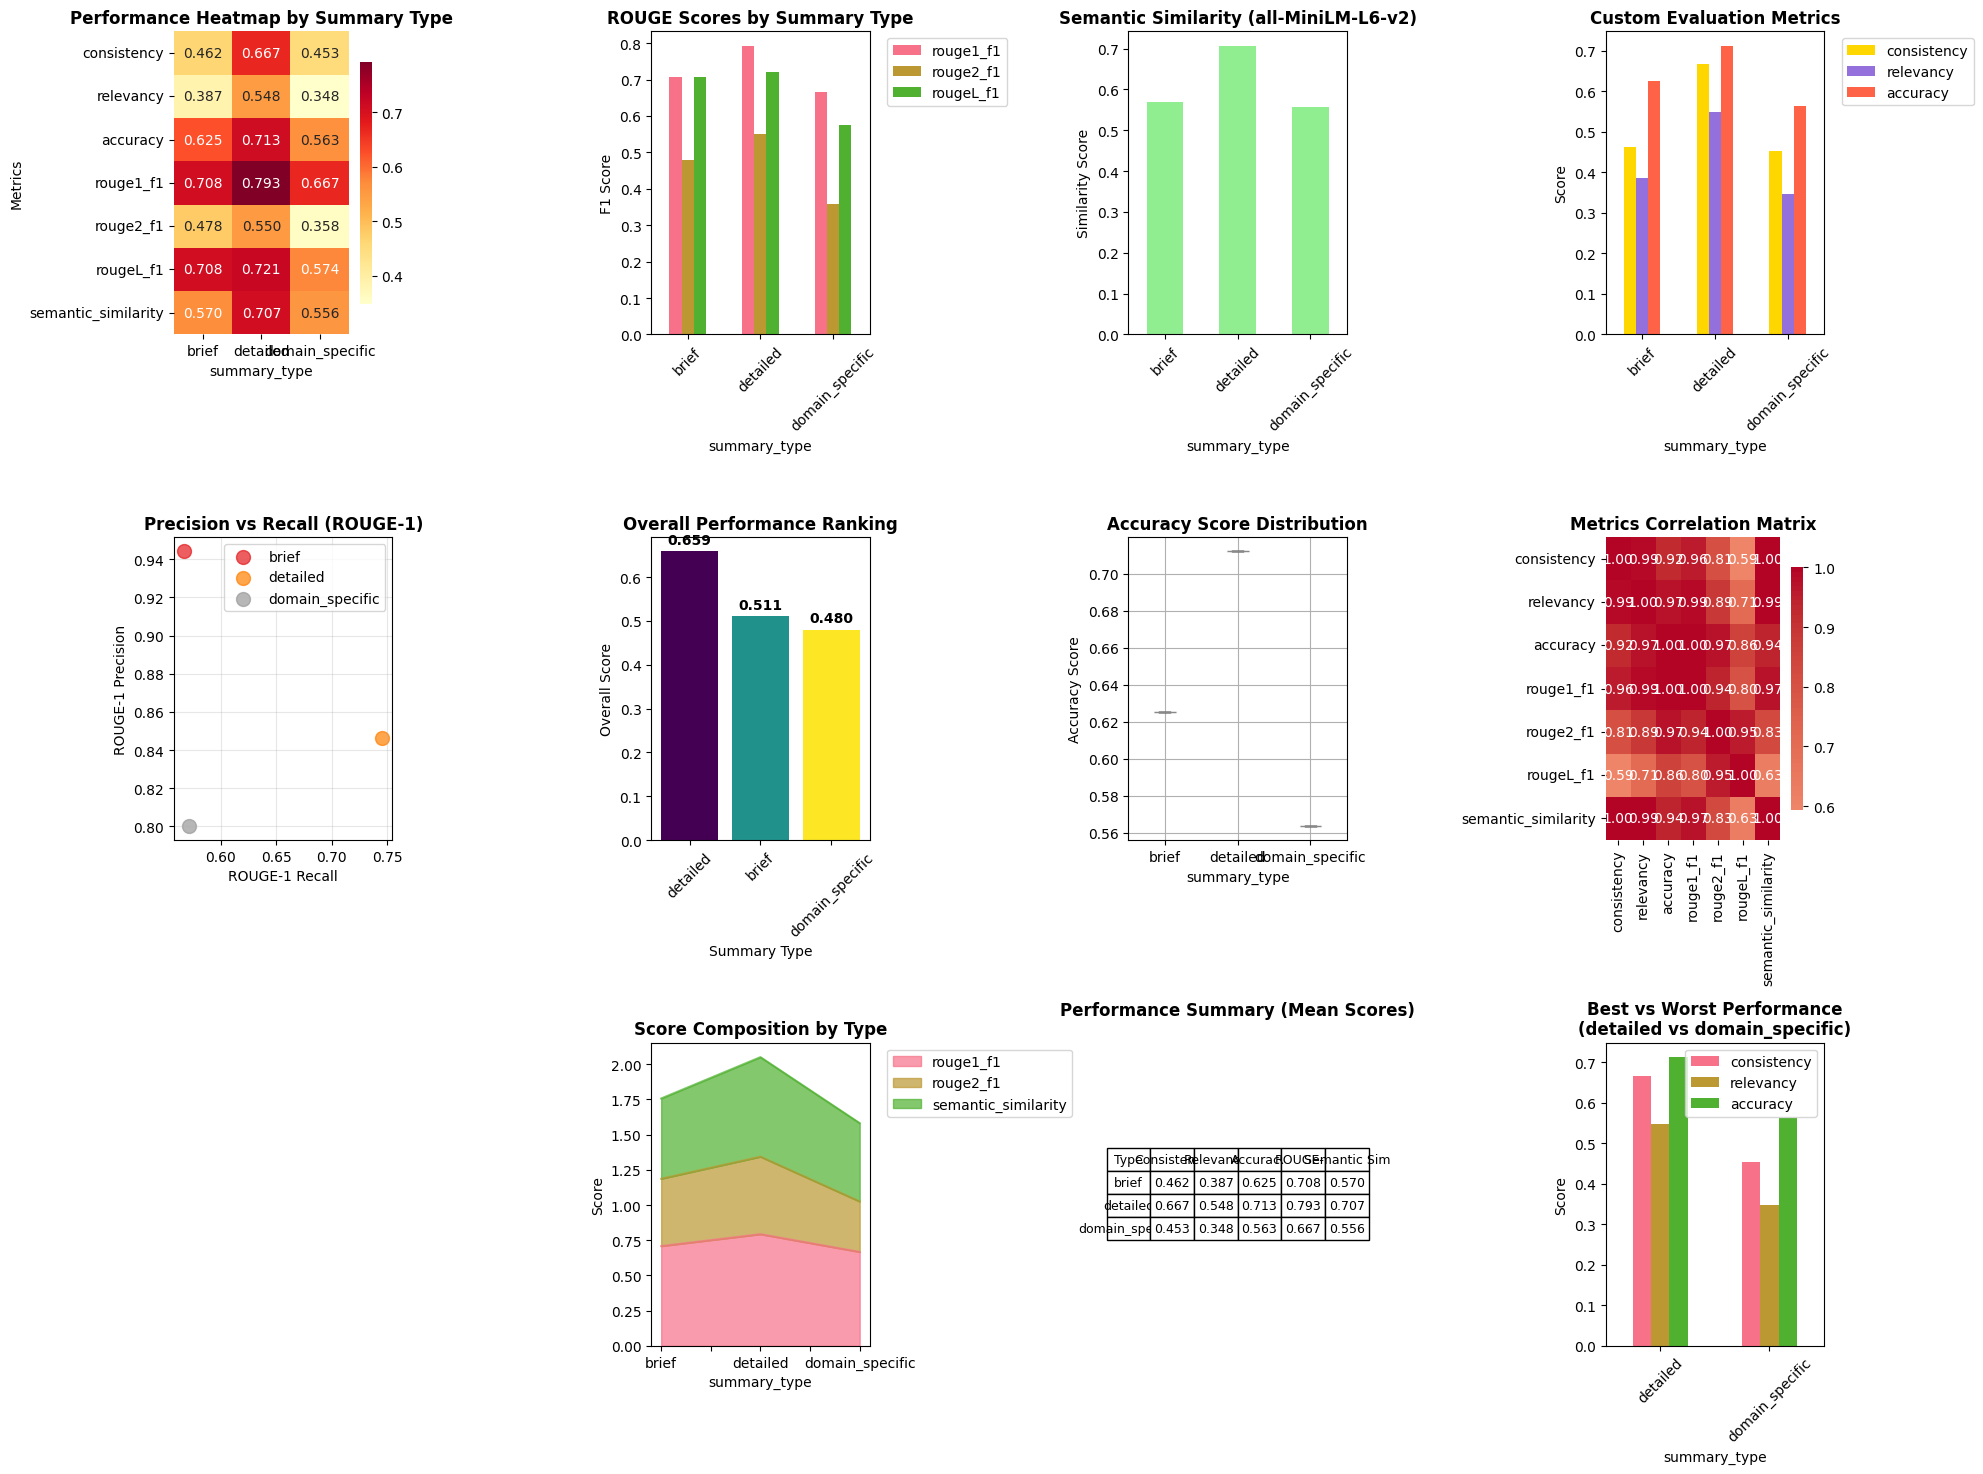

COMPREHENSIVE SUMMARY EVALUATION REPORT (HF API)
Generated: 2025-09-28 01:17:42
Total summaries evaluated: 3
Summary types: brief, detailed, domain_specific

OVERALL STATISTICS
--------------------------------------------------
       consistency  relevancy  accuracy  rouge1_f1  rouge2_f1  rougeL_f1  \
count       3.0000     3.0000    3.0000     3.0000     3.0000     3.0000   
mean        0.5270     0.4278    0.6338     0.7226     0.4624     0.6677   
std         0.1210     0.1063    0.0749     0.0643     0.0970     0.0813   
min         0.4528     0.3478    0.5635     0.6667     0.3585     0.5741   
25%         0.4572     0.3675    0.5945     0.6875     0.4184     0.6412   
50%         0.4615     0.3871    0.6254     0.7083     0.4783     0.7083   
75%         0.5641     0.4677    0.6690     0.7506     0.5144     0.7145   
max         0.6667     0.5484    0.7125     0.7928     0.5505     0.7207   

       semantic_similarity  
count               3.0000  
mean                0.6112  


In [ ]:
# Fixed Summary Evaluation System - No Circular Imports
# Save this as: summary_evaluation_system.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
import warnings
import os
from datetime import datetime
import requests
import json

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# === CONFIGURATION ===
HF_TOKEN = os.getenv(HF_TOKEN)
if not HF_TOKEN:
    raise ValueError("Please set the HF_TOKEN environment variable with your Hugging Face API token.")

# Use a model that definitely works for feature extraction
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"

def get_embeddings(sentences):
    """Get embeddings from Hugging Face Inference API using feature extraction"""
    headers = {
        "Authorization": f"Bearer {HF_TOKEN}",
        "Content-Type": "application/json"
    }
    
    # Process each sentence individually to avoid pipeline confusion
    embeddings = []
    
    for sentence in sentences:
        # Use the standard inference API endpoint
        url = f"https://api-inference.huggingface.co/models/{EMBEDDING_MODEL}"
        
        # Simple payload - just the text
        payload = {
            "inputs": sentence,
            "options": {"wait_for_model": True, "use_cache": False}
        }
        
        response = requests.post(url, headers=headers, json=payload)
        
        if response.status_code != 200:
            raise RuntimeError(f"HF API error {response.status_code}: {response.text}")
        
        result = response.json()
        
        # Handle the response - sentence transformers usually return embeddings directly
        if isinstance(result, list) and len(result) > 0:
            if isinstance(result[0], list):
                # Nested list - take first element
                embedding = result[0]
            else:
                # Flat list - this is the embedding
                embedding = result
        else:
            raise RuntimeError(f"Unexpected response format: {type(result)}")
        
        embeddings.append(embedding)
    
    return np.array(embeddings)
    
def cosine_similarity(a, b):
    """Compute cosine similarity between two vectors"""
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

class SummaryEvaluator:
    """
    Comprehensive summary evaluation system using ROUGE and semantic similarity via Hugging Face API
    """
    
    def __init__(self):
        print("Initializing evaluation system...")
        
        # Initialize ROUGE scorer (local, no model download)
        self.rouge_scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'], 
            use_stemmer=True
        )
        
        self.evaluation_results = []
        print("Evaluator initialized successfully!")
    
    def calculate_rouge_scores(self, generated_summary, reference_summary):
        """Calculate ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)"""
        scores = self.rouge_scorer.score(reference_summary, generated_summary)
        return {
            'rouge1_precision': scores['rouge1'].precision,
            'rouge1_recall': scores['rouge1'].recall,
            'rouge1_f1': scores['rouge1'].fmeasure,
            'rouge2_precision': scores['rouge2'].precision,
            'rouge2_recall': scores['rouge2'].recall,
            'rouge2_f1': scores['rouge2'].fmeasure,
            'rougeL_precision': scores['rougeL'].precision,
            'rougeL_recall': scores['rougeL'].recall,
            'rougeL_f1': scores['rougeL'].fmeasure,
        }
    
    def calculate_semantic_similarity(self, generated_summary, reference_summary):
        """Calculate semantic similarity using simple word overlap as fallback and HF API when available"""
        # First try HF API
        try:
            embeddings = get_embeddings([generated_summary, reference_summary])
            sim = cosine_similarity(embeddings[0], embeddings[1])
            return max(0.0, min(1.0, sim))  # Clamp to [0, 1]
        except Exception as api_error:
            print(f"⚠️ Semantic similarity API failed: {api_error}")
            # Fallback to advanced word-based similarity
            return self._calculate_word_based_similarity(generated_summary, reference_summary)
    
    def _calculate_word_based_similarity(self, text1, text2):
        """Advanced word-based similarity as fallback"""
        import re
        from collections import Counter
        
        # Clean and tokenize
        def clean_tokenize(text):
            # Remove punctuation and convert to lowercase
            text = re.sub(r'[^\w\s]', '', text.lower())
            return text.split()
        
        tokens1 = clean_tokenize(text1)
        tokens2 = clean_tokenize(text2)
        
        if not tokens1 or not tokens2:
            return 0.0
            
        # Calculate different similarity measures
        # 1. Jaccard similarity
        set1, set2 = set(tokens1), set(tokens2)
        jaccard = len(set1.intersection(set2)) / len(set1.union(set2)) if set1.union(set2) else 0.0
        
        # 2. Cosine similarity based on word counts
        counter1 = Counter(tokens1)
        counter2 = Counter(tokens2)
        
        # Get all unique words
        all_words = set(counter1.keys()).union(set(counter2.keys()))
        
        # Create vectors
        vec1 = [counter1.get(word, 0) for word in all_words]
        vec2 = [counter2.get(word, 0) for word in all_words]
        
        # Calculate cosine similarity
        dot_product = sum(a * b for a, b in zip(vec1, vec2))
        norm1 = sum(a * a for a in vec1) ** 0.5
        norm2 = sum(a * a for a in vec2) ** 0.5
        
        cosine_sim = dot_product / (norm1 * norm2) if norm1 and norm2 else 0.0
        
        # 3. Length-normalized overlap
        overlap = len(set1.intersection(set2))
        max_len = max(len(set1), len(set2))
        length_norm_sim = overlap / max_len if max_len else 0.0
        
        # Combine metrics (weighted average)
        combined_sim = 0.4 * jaccard + 0.4 * cosine_sim + 0.2 * length_norm_sim
        
        print(f"📊 Using fallback similarity: {combined_sim:.3f} (Jaccard: {jaccard:.3f}, Cosine: {cosine_sim:.3f})")
        return combined_sim

    def calculate_consistency_score(self, generated_summary, reference_summary):
        gen_words = set(generated_summary.lower().split())
        ref_words = set(reference_summary.lower().split())
        if len(ref_words) == 0:
            return 0.0
        overlap = len(gen_words.intersection(ref_words))
        return overlap / len(ref_words)
    
    def calculate_relevancy_score(self, generated_summary, reference_summary):
        gen_words = set(generated_summary.lower().split())
        ref_words = set(reference_summary.lower().split())
        union = gen_words.union(ref_words)
        if len(union) == 0:
            return 0.0
        return len(gen_words.intersection(ref_words)) / len(union)
    
    def calculate_accuracy_score(self, generated_summary, reference_summary):
        rouge_scores = self.calculate_rouge_scores(generated_summary, reference_summary)
        semantic_sim = self.calculate_semantic_similarity(generated_summary, reference_summary)
        # Same weighting: 40% ROUGE-L, 60% semantic similarity
        accuracy = 0.4 * rouge_scores['rougeL_f1'] + 0.6 * semantic_sim
        return accuracy
    
    def evaluate_summary(self, generated_summary, reference_summary, summary_type, document_id=None):
        print(f"Evaluating {summary_type} summary...")
        
        rouge_metrics = self.calculate_rouge_scores(generated_summary, reference_summary)
        semantic_sim = self.calculate_semantic_similarity(generated_summary, reference_summary)
        consistency = self.calculate_consistency_score(generated_summary, reference_summary)
        relevancy = self.calculate_relevancy_score(generated_summary, reference_summary)
        accuracy = self.calculate_accuracy_score(generated_summary, reference_summary)
        
        evaluation_result = {
            'document_id': document_id or f"doc_{len(self.evaluation_results)}",
            'summary_type': summary_type,
            'generated_summary': generated_summary,
            'reference_summary': reference_summary,
            'consistency': consistency,
            'relevancy': relevancy,
            'accuracy': accuracy,
            'semantic_similarity': semantic_sim,  # Replaces all BERTScore metrics
            **rouge_metrics
        }
        
        self.evaluation_results.append(evaluation_result)
        print(f"Completed evaluation for {summary_type}")
        return evaluation_result
    
    def evaluate_multiple_summaries(self, summary_data):
        print(f"Starting batch evaluation of {len(summary_data)} summaries...")
        results = []
        for i, data in enumerate(summary_data):
            print(f"Processing summary {i+1}/{len(summary_data)}")
            result = self.evaluate_summary(
                generated_summary=data['generated_summary'],
                reference_summary=data['reference_summary'],
                summary_type=data['summary_type'],
                document_id=data.get('document_id', f"doc_{len(results)}")
            )
            results.append(result)
        print("Batch evaluation completed!")
        return results
    
    def get_results_dataframe(self):
        return pd.DataFrame(self.evaluation_results)
    
    def create_comprehensive_visualization(self, save_path=None):
        if not self.evaluation_results:
            print("No evaluation results available.")
            return
            
        df = self.get_results_dataframe()
        
        fig = plt.figure(figsize=(20, 15))
        fig.suptitle('Summary Evaluation Dashboard (HF API - all-MiniLM-L6-v2)', fontsize=16, fontweight='bold', y=0.98)
        
        # 1. Performance Heatmap (updated to use semantic_similarity)
        plt.subplot(3, 4, 1)
        metrics_cols = ['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'semantic_similarity']
        heatmap_data = df.groupby('summary_type')[metrics_cols].mean()
        sns.heatmap(heatmap_data.T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'shrink': 0.8})
        plt.title('Performance Heatmap by Summary Type', fontsize=12, fontweight='bold')
        plt.ylabel('Metrics')
        
        # 2. ROUGE Scores
        plt.subplot(3, 4, 2)
        rouge_metrics = ['rouge1_f1', 'rouge2_f1', 'rougeL_f1']
        rouge_data = df.groupby('summary_type')[rouge_metrics].mean()
        rouge_data.plot(kind='bar', ax=plt.gca())
        plt.title('ROUGE Scores by Summary Type', fontsize=12, fontweight='bold')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 3. Semantic Similarity (replaces BERTScore plot)
        plt.subplot(3, 4, 3)
        sem_data = df.groupby('summary_type')['semantic_similarity'].mean()
        sem_data.plot(kind='bar', ax=plt.gca(), color='lightgreen')
        plt.title('Semantic Similarity (all-MiniLM-L6-v2)', fontsize=12, fontweight='bold')
        plt.ylabel('Similarity Score')
        plt.xticks(rotation=45)
        
        # 4. Custom Metrics
        plt.subplot(3, 4, 4)
        custom_metrics = ['consistency', 'relevancy', 'accuracy']
        custom_data = df.groupby('summary_type')[custom_metrics].mean()
        custom_data.plot(kind='bar', ax=plt.gca(), color=['gold', 'mediumpurple', 'tomato'])
        plt.title('Custom Evaluation Metrics', fontsize=12, fontweight='bold')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 5. Precision vs Recall Scatter
        plt.subplot(3, 4, 5)
        summary_types = df['summary_type'].unique()
        colors = plt.cm.Set1(np.linspace(0, 1, len(summary_types)))
        for i, summary_type in enumerate(summary_types):
            subset = df[df['summary_type'] == summary_type]
            plt.scatter(subset['rouge1_recall'], subset['rouge1_precision'], 
                       label=summary_type, alpha=0.7, s=100, color=colors[i])
        plt.xlabel('ROUGE-1 Recall')
        plt.ylabel('ROUGE-1 Precision')
        plt.title('Precision vs Recall (ROUGE-1)', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Overall Performance Ranking
        plt.subplot(3, 4, 6)
        df['overall_score'] = (0.25 * df['consistency'] + 0.25 * df['relevancy'] + 
                              0.25 * df['accuracy'] + 0.25 * df['semantic_similarity'])
        overall_ranking = df.groupby('summary_type')['overall_score'].mean().sort_values(ascending=False)
        bars = plt.bar(range(len(overall_ranking)), overall_ranking.values, 
                      color=plt.cm.viridis(np.linspace(0, 1, len(overall_ranking))))
        plt.title('Overall Performance Ranking', fontsize=12, fontweight='bold')
        plt.xlabel('Summary Type')
        plt.ylabel('Overall Score')
        plt.xticks(range(len(overall_ranking)), overall_ranking.index, rotation=45)
        for bar, value in zip(bars, overall_ranking.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 7. Accuracy Distribution
        plt.subplot(3, 4, 7)
        df.boxplot(column='accuracy', by='summary_type', ax=plt.gca())
        plt.title('Accuracy Score Distribution', fontsize=12, fontweight='bold')
        plt.suptitle('')
        plt.ylabel('Accuracy Score')
        
        # 8. Correlation Matrix
        plt.subplot(3, 4, 8)
        correlation_cols = ['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'semantic_similarity']
        correlation_matrix = df[correlation_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Metrics Correlation Matrix', fontsize=12, fontweight='bold')
        
        # Skip BERT model comparison plots (9, 10 partially updated)
        # 9. Semantic similarity is already shown in plot 3
        
        # 10. Performance Trends
        plt.subplot(3, 4, 10)
        if len(df['document_id'].unique()) > 1:
            trend_data = df.groupby(['document_id', 'summary_type'])['accuracy'].mean().unstack(fill_value=0)
            trend_data.plot(ax=plt.gca(), marker='o')
            plt.title('Accuracy Trends Across Documents', fontsize=12, fontweight='bold')
            plt.xlabel('Document ID')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.legend(title='Summary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            score_breakdown = df.groupby('summary_type')[['rouge1_f1', 'rouge2_f1', 'semantic_similarity']].mean()
            score_breakdown.plot(kind='area', ax=plt.gca(), alpha=0.7)
            plt.title('Score Composition by Type', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 11. Summary Statistics Table
        plt.subplot(3, 4, 11)
        plt.axis('off')
        summary_stats = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'semantic_similarity']].mean().round(3)
        table_data = []
        for summary_type in summary_stats.index:
            row = [summary_type]
            for col in summary_stats.columns:
                row.append(f"{summary_stats.loc[summary_type, col]:.3f}")
            table_data.append(row)
        table = plt.table(cellText=table_data,
                         colLabels=['Type', 'Consistency', 'Relevancy', 'Accuracy', 'ROUGE-1', 'Semantic Sim'],
                         cellLoc='center',
                         loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Performance Summary (Mean Scores)', fontsize=12, fontweight='bold', pad=20)
        
        # 12. Best vs Worst
        plt.subplot(3, 4, 12)
        best_type = overall_ranking.index[0]
        worst_type = overall_ranking.index[-1] if len(overall_ranking) > 1 else best_type
        if best_type != worst_type:
            comparison_data = df[df['summary_type'].isin([best_type, worst_type])]
            comparison_means = comparison_data.groupby('summary_type')[['consistency', 'relevancy', 'accuracy']].mean()
            comparison_means.plot(kind='bar', ax=plt.gca())
            plt.title(f'Best vs Worst Performance\n({best_type} vs {worst_type})', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.xticks(rotation=45)
            plt.legend()
        else:
            single_type_data = df[df['summary_type'] == best_type][['consistency', 'relevancy', 'accuracy']].mean()
            single_type_data.plot(kind='bar', ax=plt.gca(), color='skyblue')
            plt.title(f'Metric Breakdown: {best_type}', fontsize=12, fontweight='bold')
            plt.ylabel('Score')
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        plt.show()
    
    def generate_detailed_report(self):
        if not self.evaluation_results:
            print("No evaluation results available.")
            return None
            
        df = self.get_results_dataframe()
        print("="*80)
        print("COMPREHENSIVE SUMMARY EVALUATION REPORT (HF API)")
        print("="*80)
        print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Total summaries evaluated: {len(df)}")
        print(f"Summary types: {', '.join(df['summary_type'].unique())}")
        print()
        
        print("OVERALL STATISTICS")
        print("-"*50)
        overall_stats = df[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'semantic_similarity']].describe()
        print(overall_stats.round(4))
        print()
        
        print("PERFORMANCE BY SUMMARY TYPE")
        print("-"*50)
        type_performance = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'semantic_similarity']].mean()
        print(type_performance.round(4))
        print()
        
        print("BEST PERFORMING SUMMARY TYPE")
        print("-"*50)
        df['overall_score'] = (0.25 * df['consistency'] + 0.25 * df['relevancy'] + 
                              0.25 * df['accuracy'] + 0.25 * df['semantic_similarity'])
        best_type = df.groupby('summary_type')['overall_score'].mean().idxmax()
        best_score = df.groupby('summary_type')['overall_score'].mean().max()
        print(f"Best Summary Type: {best_type}")
        print(f"Overall Score: {best_score:.4f}")
        
        print(f"\nDetailed metrics for '{best_type.upper()}':")
        print("-"*30)
        best_metrics = df[df['summary_type'] == best_type][['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'rouge2_f1', 'rougeL_f1', 'semantic_similarity']].mean()
        for metric, value in best_metrics.items():
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
        
        print(f"\nRECOMMENDATIONS")
        print("-"*50)
        type_scores = df.groupby('summary_type')[['consistency', 'relevancy', 'accuracy', 'rouge1_f1', 'semantic_similarity']].mean()
        for summary_type in type_scores.index:
            print(f"\n{summary_type.upper()} Summary:")
            scores = type_scores.loc[summary_type]
            strengths = scores.nlargest(2).index.tolist()
            weaknesses = scores.nsmallest(2).index.tolist()
            print(f"  Strengths: {', '.join([s.replace('_', ' ').title() for s in strengths])}")
            print(f"  Areas for improvement: {', '.join([w.replace('_', ' ').title() for w in weaknesses])}")
        print(f"\nOverall recommendation: Focus on improving '{best_type}' approach")
        return df


def demo_evaluation():
    print("Starting HF API-based evaluation demo...")
    os.makedirs('test', exist_ok=True)
    
    sample_summaries = [
        {
            'document_id': 'medical_doc_1',
            'summary_type': 'brief',
            'generated_summary': 'Patient has iron deficiency anaemia and beta thalassaemia trait. Blood tests show microcytic anaemia. Treatment includes iron supplementation.',
            'reference_summary': 'The patient was diagnosed with iron deficiency anaemia and beta thalassaemia trait based on blood test results showing microcytic anaemia. The treatment plan includes iron supplementation and follow-up monitoring.'
        },
        {
            'document_id': 'medical_doc_1', 
            'summary_type': 'detailed',
            'generated_summary': 'Patient K B Chunchaiah, age 45, was admitted with iron deficiency anaemia and beta thalassaemia trait. Laboratory results revealed microcytic anaemia with elevated Mentzer index. The patient presented with symptoms of fatigue and pallor. Current treatment includes ferrous sulfate 200mg daily with planned follow-up in 2 months to monitor hemoglobin levels.',
            'reference_summary': 'Patient K B Chunchaiah, 45 years old, was admitted to hospital with iron deficiency anaemia and beta thalassaemia trait. Blood tests showed microcytic anaemia with elevated Mentzer index. The patient has a history of fatigue and pallor. Current medications include Ferrous Sulfate 200mg daily. Treatment plan includes continuing iron supplementation and follow-up in 2 months with hemoglobin monitoring.'
        },
        {
            'document_id': 'medical_doc_1',
            'summary_type': 'domain_specific', 
            'generated_summary': 'Medical diagnosis: Iron deficiency anaemia with beta thalassaemia trait. Key findings: Microcytic anaemia, elevated Mentzer index (>13), symptoms of fatigue and pallor. Treatment protocol: Ferrous sulfate supplementation with 2-month follow-up schedule. Diagnostic note: HbA2 estimation remains gold standard for beta thalassaemia trait diagnosis.',
            'reference_summary': 'Primary diagnosis of iron deficiency anaemia complicated by beta thalassaemia trait in 45-year-old male patient. Laboratory findings include microcytic anaemia with Mentzer index >13. Clinical presentation includes fatigue and pallor. Treatment regimen consists of ferrous sulfate 200mg daily with scheduled follow-up in 2 months for hemoglobin monitoring. Note that HbA2 estimation is the gold standard for diagnosing beta thalassaemia trait.'
        }
    ]
    
    evaluator = SummaryEvaluator()
    results = evaluator.evaluate_multiple_summaries(sample_summaries)
    evaluator.create_comprehensive_visualization(save_path='test/hf_summary_dashboard.png')
    df_results = evaluator.generate_detailed_report()
    df_results.to_csv('test/hf_evaluation_results.csv', index=False)
    print("Results saved to test/hf_evaluation_results.csv")
    return evaluator, df_results


if __name__ == "__main__":
    print("Running Hugging Face API-Based Summary Evaluation Demo...")
    print("Make sure to set: export HF_TOKEN='your_hf_token'")
    print("="*60)
    
    try:
        evaluator, results_df = demo_evaluation()
        print("\n✅ Demo completed successfully!")
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()